In [1]:
import numpy as np
import porespy as ps
import scipy.ndimage as spim
import matplotlib.pyplot as plt
import skimage

In [2]:
import sys
import dask
import dask.array as da
from dask.diagnostics import ProgressBar
import warnings
import numpy as np
from numba import njit, prange
from edt import edt
import operator as op
from tqdm import tqdm
import scipy.ndimage as spim
import scipy.spatial as sptl
from collections import namedtuple
from skimage.morphology import reconstruction
from skimage.segmentation import clear_border, watershed
from skimage.morphology import ball, disk, square, cube, diamond, octahedron
from porespy.tools import randomize_colors, fftmorphology
from porespy.tools import get_border, extend_slice, extract_subsection
from porespy.tools import _create_alias_map
from porespy.tools import ps_disk, ps_ball


Set's the value of each voxel to the highest value that is found on the voxel's axis. The axis used is selected in the input.

Create input image and set axis value:

--------------------------------------------------------------------------------
RSA: Adding spheres of size 5
Initial volume fraction: 0.0
Dilating foreground features by sphere radius
Regenerating free_sites after 459 iterations
Regenerating free_sites after 570 iterations
Regenerating free_sites after 602 iterations
Number of spheres inserted: 602
Final volume fraction: 0.46153333333333335


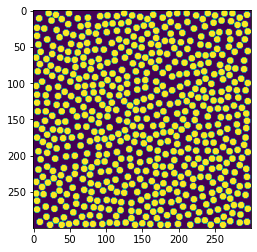

In [3]:
im = np.zeros([300, 300])
im = ps.generators.RSA(im, radius=5, volume_fraction=0.5)
axis=-1
plt.imshow(im)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


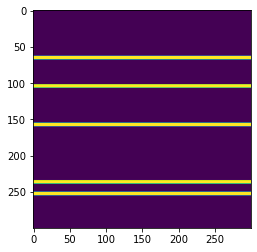

In [4]:
r"""
    Replaces each voxel with the highest value along the given axis
    Parameters
    ----------
    im : ND-image
        A greyscale image whose peaks are to
    """
A = im
B = np.swapaxes(A, axis, -1)
updown = np.empty((*B.shape[:-1], B.shape[-1] + 1), B.dtype)
updown[..., 0], updown[..., -1] = -1, -1
np.bitwise_xor(B[..., 1:], B[..., :-1], out=updown[..., 1:-1])
chnidx = np.where(updown)
chng = updown[chnidx]
(pkidx,) = np.where((chng[:-1] > 0) & (chng[1:] < 0) | (chnidx[-1][:-1] == 0))
pkidx = (*map(op.itemgetter(pkidx), chnidx),)
out = np.zeros_like(A)
aux = out.swapaxes(axis, -1)
aux[(*map(op.itemgetter(slice(1, None)), pkidx),)] = np.diff(B[pkidx])
aux[..., 0] = B[..., 0]
result = out.cumsum(axis=axis)
print(result)
plt.imshow(result)


Apply filter:

In [5]:
ps.filters.hold_peaks(im, axis)


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.